In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/My\ Drive/Advanced\ Computer\ Vision\ (\CS\ 893)\/Assignment3

/content/drive/My Drive/Advanced Computer Vision (CS 893)/Assignment3


In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
# Set some parameters
im_width = 1024
im_height = 1024
border = 5

In [5]:
ids = next(os.walk("MonuSeg/Training/TissueImages"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  30


In [6]:
ids_test = next(os.walk("MonuSeg/Test/TissueImages"))[2]
print("No. of images = ", len(ids_test))

No. of images =  14


In [0]:
X_train = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y_train = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
X_valid = np.zeros((len(ids_test), im_height, im_width, 1), dtype=np.float32)
y_valid = np.zeros((len(ids_test), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [8]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("MonuSeg/Training/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (1024, 1024, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("MonuSeg/Training/GroundTruth/"+id_.split('.')[0]+"_bin_mask"+".png", grayscale=True))
    mask = resize(mask, (1024, 1024, 1), mode = 'constant', preserve_range = True)
    # Save images
    X_train[n] = x_img/255.0
    y_train[n] = mask/255.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [9]:
# loading test images and masks
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("MonuSeg/Test/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (1024, 1024, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("MonuSeg/Test/GroundTruth/"+id_.split('.')[0]+"_bin_mask"+".png", grayscale=True))
    mask = resize(mask, (1024, 1024, 1), mode = 'constant', preserve_range = True)
    # Save images
    X_valid[n] = x_img/255.0
    y_valid[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
# Split train and valid
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'Mask')

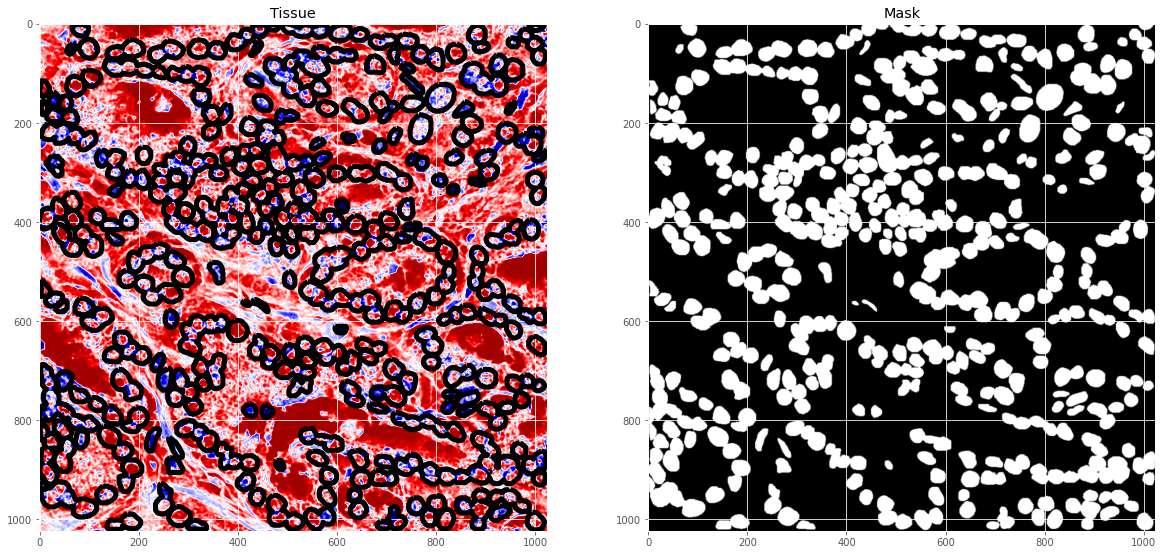

In [11]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask:
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Tissue')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [14]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=SGD(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1024, 1024, 1 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 1024, 1024, 1 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 1024, 1024, 1 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [17]:
results = model.fit(X_train, y_train, batch_size=5, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))



Train on 30 samples, validate on 14 samples
Epoch 1/50
30/30 [==============================] - 151s 5s/step - loss: 0.7058 - acc: 0.6605 - val_loss: 0.6281 - val_acc: 0.7376

Epoch 00001: val_loss improved from inf to 0.62808, saving model to model-tgs-salt.h5
Epoch 2/50
30/30 [==============================] - 147s 5s/step - loss: 0.6903 - acc: 0.6645 - val_loss: 0.6126 - val_acc: 0.7397

Epoch 00002: val_loss improved from 0.62808 to 0.61256, saving model to model-tgs-salt.h5
Epoch 3/50
30/30 [==============================] - 147s 5s/step - loss: 0.6812 - acc: 0.6667 - val_loss: 0.5972 - val_acc: 0.7415

Epoch 00003: val_loss improved from 0.61256 to 0.59725, saving model to model-tgs-salt.h5
Epoch 4/50
30/30 [==============================] - 147s 5s/step - loss: 0.6708 - acc: 0.6692 - val_loss: 0.5831 - val_acc: 0.7432

Epoch 00004: val_loss improved from 0.59725 to 0.58311, saving model to model-tgs-salt.h5
Epoch 5/50
30/30 [==============================] - 147s 5s/step - los

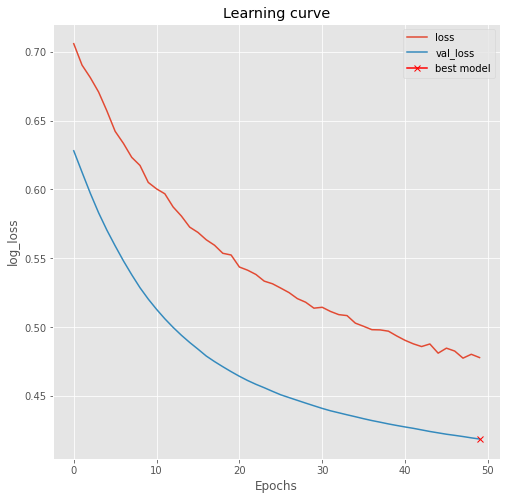

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [0]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [20]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

14/14 [==============================] - 16s 1s/step


[0.41885513067245483, 0.8200928568840027]

In [21]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

14/14 [==============================] - 16s 1s/step


In [0]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=-1)
  union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [60]:
dice_coef(y_valid, preds_val)

<tf.Tensor 'Mean_8:0' shape=(1024, 1024) dtype=float32>

In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Tissue')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Mask Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Mask Predicted binary');

### Predictions on training set

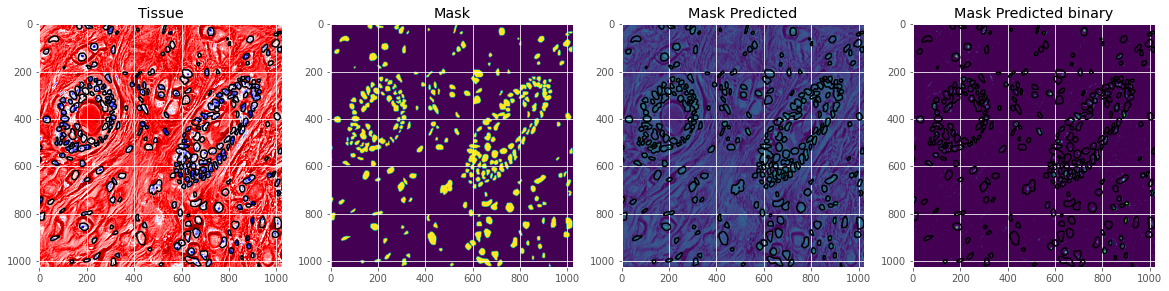

In [24]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

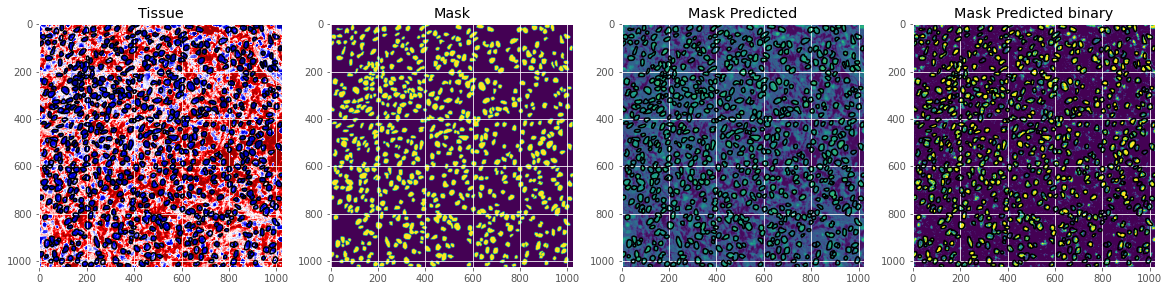

In [25]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

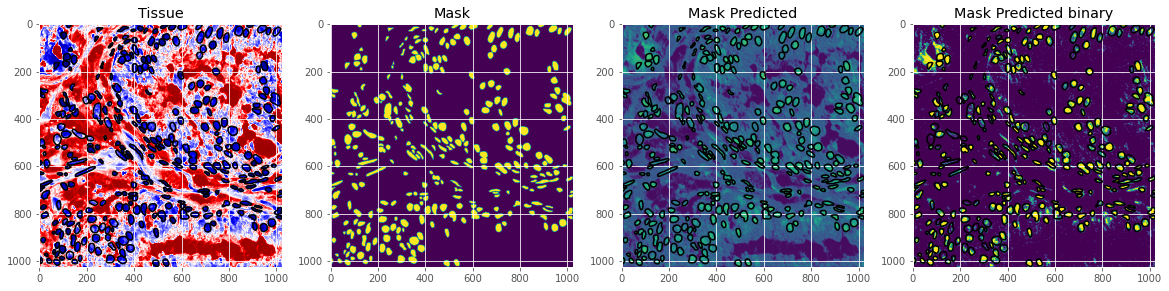

In [26]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=10)

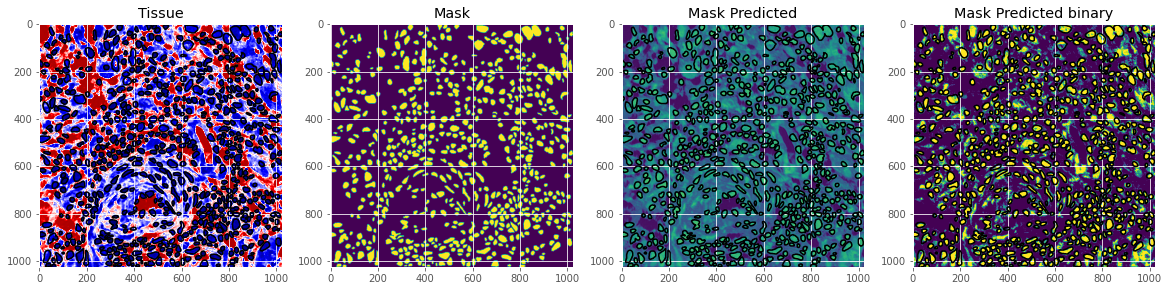

In [27]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)